In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from skimage.feature import hog
from skimage import exposure
from PIL import Image


In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fthnaja/kain-ulos
!unzip kain-ulos.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/fthnaja/kain-ulos
License(s): MIT
100% 2.45G/2.47G [00:38<00:00, 118MB/s] 
100% 2.47G/2.47G [00:39<00:00, 67.6MB/s]
Archive:  kain-ulos.zip
  inflating: Test/Pinuncaan/IMG_20240611_201106.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201107.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201107_1.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201107_11.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201108.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201108_1.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201108_11.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201108_2.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201108_22.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201109.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201110.jpg  
  inflating: Test/Pinuncaan/IMG_20240611_201114 4.jpg  
  inflating: Test

In [3]:
train_path = "Train"
test_path = "Test"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [4]:
def extract_features_from_image(img_path):
    """
    Fungsi untuk mengubah gambar menjadi vektor fitur menggunakan HOG.
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img)

    fd, hog_image = hog(img_array, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                        visualize=True, channel_axis=-1)


    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return fd

In [5]:
def load_and_process_data(train_path):
    """
    Membaca gambar dan mengekstrak fitur HOG untuk semua gambar dalam dataset.
    """
    features = []
    labels = []
    class_names = os.listdir(train_path)

    for cls in class_names:
        class_folder = os.path.join(train_path, cls)
        image_files = os.listdir(class_folder)

        for img_name in image_files:
            img_path = os.path.join(class_folder, img_name)


            feature = extract_features_from_image(img_path)
            features.append(feature)
            labels.append(cls)

    return np.array(features), np.array(labels), class_names


In [6]:
X, y, class_names = load_and_process_data(train_path)


In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [9]:
from sklearn.model_selection import GridSearchCV

for random_state_value in [42, 0, 101, 4, 8]:
  X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=random_state_value)

  param_grid = {
      'n_neighbors': list(range(1, 21)),
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan', 'minkowski'],
      'p': [1, 2, 3]
  }

  grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
  grid_search.fit(X_train, y_train)

  print(f"Results for random_state = {random_state_value}:")
  print("Best Hyperparameters:", grid_search.best_params_)
  print("Best Accuracy:", grid_search.best_score_)

Results for random_state = 42:
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Accuracy: 0.9140692894891368
Results for random_state = 0:
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Accuracy: 0.9202701115678215
Results for random_state = 101:
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Accuracy: 0.9171579565472696
Results for random_state = 4:
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Accuracy: 0.9309806224310042
Results for random_state = 8:
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best Accuracy: 0.911051086318262


In [10]:
  best_knn = grid_search.best_estimator_
  y_pred = best_knn.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.4f}")

from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Accuracy: 0.9571
Random Forest Accuracy: 0.8589
              precision    recall  f1-score   support

   Pinuncaan       0.84      0.90      0.87        29
  Ragi Hidup       0.65      0.81      0.72        21
 Ragi Hotang       0.93      0.93      0.93        27
       Sadum       0.89      0.89      0.89        28
    Sibolang       0.96      0.79      0.87        34
    Tumtuman       0.87      0.83      0.85        24

    accuracy                           0.86       163
   macro avg       0.86      0.86      0.86       163
weighted avg       0.87      0.86      0.86       163



In [11]:
def predict_image_knn(img_path):
    """
    Fungsi untuk memprediksi gambar baru menggunakan model KNN.
    """
    try:
        feature = extract_features_from_image(img_path)
        feature = feature.reshape(1, -1)

        prediction = best_knn.predict(feature)
        predicted_class = le.inverse_transform(prediction)[0]

        img = image.load_img(img_path, target_size=IMG_SIZE)
        plt.imshow(img)
        plt.title(f"Prediksi: {predicted_class}")
        plt.show()
    except Exception as e:
        print(f"Error during prediction: {e}")
        print(f"Check if the image path '{img_path}' is correct and the image is readable.")

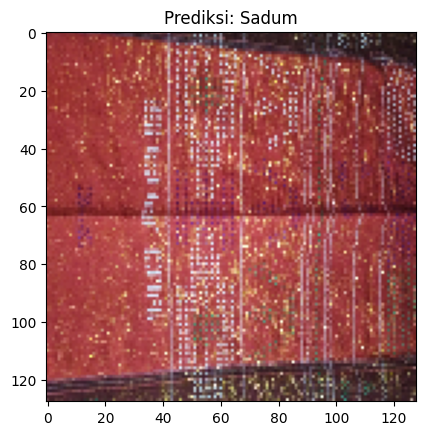

In [15]:
img_path = 'IMG_20240705_231530_39.jpg'
predict_image_knn(img_path)